In [92]:
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import import_ipynb
from sklearn.model_selection import GroupShuffleSplit
import numpy_indexed as npi
from scipy import stats
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D,Dropout,Flatten,MaxPooling2D, Input
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import librosa.display

In [64]:
path = '/Users/deiry/ML/Voice_Recognition/data/mel-spectrograms_7500.hd5'

In [65]:
df = pd.read_hdf(path)
df.shape

(7500, 3)

In [125]:
df.tail()

,mel-spectrogram,speaker,word
7495,"[[825.86426, 823.86835, 823.74115, 823.8642, 8...",916,1
7496,"[[1321.0461, 1318.3152, 1318.8292, 1319.0348, ...",916,1
7497,"[[1288.8186, 1288.5488, 1288.7296, 1288.8041, ...",916,1
7498,"[[1390.5499, 1390.8105, 1390.8024, 1390.8684, ...",916,1
7499,"[[1064.0765, 1065.097, 1064.8335, 1064.9655, 1...",916,1


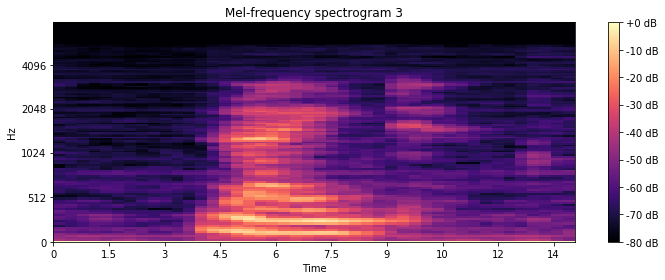

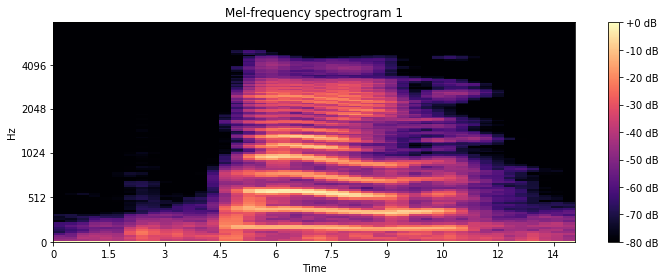

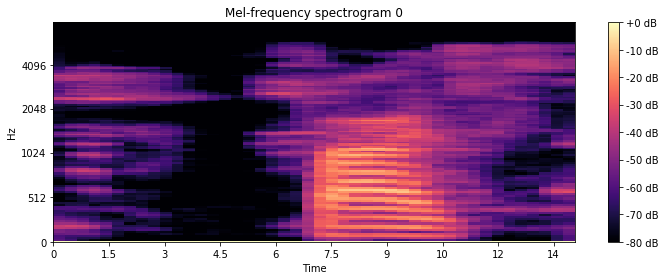

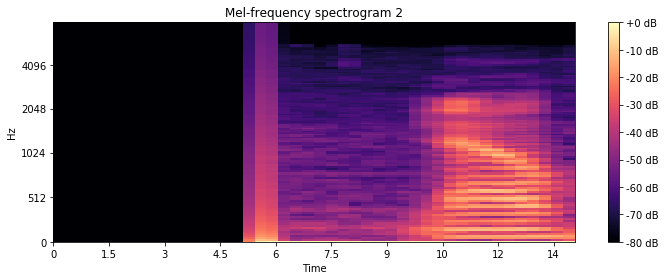

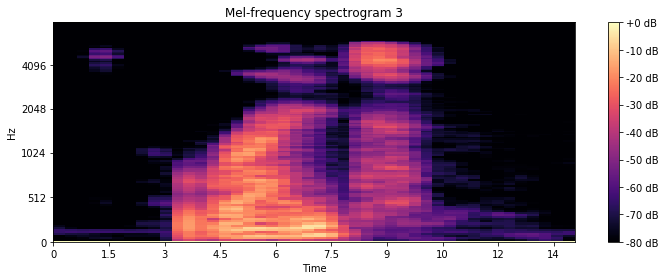

In [102]:

for i in range(0,5):
    pos = np.random.randint(0, len(df))
    img = df['mel-spectrogram'][pos]
    plt.figure(figsize=(10, 4))
    S_dB = librosa.power_to_db(img, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=1600,
                            fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram '+ str(df['word'][pos]))
    plt.tight_layout()
    plt.show()


In [66]:
test_size = 0.2

In [67]:
def buildX(X, input_shape):    
    Xreshape = np.zeros(input_shape)
    c = 0
    for i in X:
        i = np.expand_dims(i, axis=3)
        Xreshape[c,:,:,:]=i
        c =c +1
    return Xreshape


def reshapeDataset(df):
    (width, heigth) = df['mel-spectrogram'][0].shape
    channel = 1
    shape_X = (len(df),width, heigth, channel)
    input_shape_cnn = (width, heigth, channel)
    print("Shape final ",shape_X)
    X = buildX(df['mel-spectrogram'].values, shape_X)
    print("Input CNN ",input_shape_cnn)
    y = df.word.values
    groups = df.speaker.values
    
    return X,y,groups, input_shape_cnn

def splitDatasetbyGroup(X,Y, groups, test_size):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    gss.get_n_splits()

    for train_index, test_index in gss.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        groups_train = groups[train_index]
        groups_test =groups[test_index]
        
    return X_train, X_test, Y_train, Y_test, groups_train, groups_test
    
def buildCNN(input_shape, num_classes):

    model = Sequential()

    img= Input(shape=input_shape)

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    validity = model(img)

    Model(img, validity)


    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    return model



In [68]:
X,y,groups, input_shape = reshapeDataset(df)

Shape final  (7500, 128, 44, 1)
Input CNN  (128, 44, 1)


ValueError: too many values to unpack (expected 2)

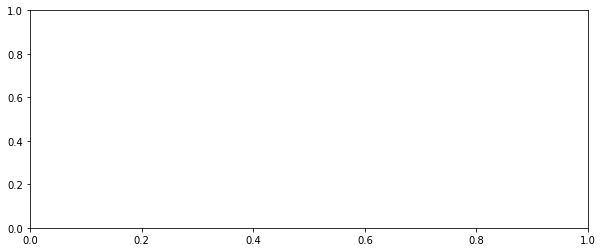

(128, 44, 1)


TypeError: Invalid shape (128, 44, 1) for image data

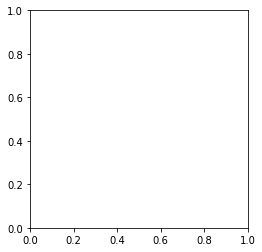

In [84]:
img = X[0]
print(img.shape)


In [76]:
y

array([4, 4, 4, ..., 1, 1, 1], dtype=object)

In [69]:
X_train, X_test, Y_train, y_test, groups_train, groups_test = splitDatasetbyGroup(X,y, groups, test_size)
y_trainOHE = utils.to_categorical(Y_train)
y_testONE = utils.to_categorical(y_test) 
num_classes = y_trainOHE.shape[1]

In [70]:
print(X_train.shape, y_trainOHE.shape)

(5962, 128, 44, 1) (5962, 5)


In [71]:
model = buildCNN(input_shape, num_classes)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 126, 42, 32)       320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 124, 40, 64)       18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 20, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 62, 20, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 79360)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               10158208  
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

In [72]:
history = model.fit(X_train, y_trainOHE, epochs=80, batch_size=100, validation_split=0.20, verbose=1)

Train on 4769 samples, validate on 1193 samples
Epoch 1/80
4769/4769 [==============================] - 92s 19ms/sample - loss: 5.8549 - accuracy: 0.3040 - val_loss: 3.5141 - val_accuracy: 0.0000e+00
Epoch 2/80
4769/4769 [==============================] - 74s 16ms/sample - loss: 1.3419 - accuracy: 0.3869 - val_loss: 5.2777 - val_accuracy: 0.0000e+00
Epoch 3/80
4769/4769 [==============================] - 67s 14ms/sample - loss: 1.1629 - accuracy: 0.5070 - val_loss: 5.9746 - val_accuracy: 0.0000e+00
Epoch 4/80
4769/4769 [==============================] - 65s 14ms/sample - loss: 0.9180 - accuracy: 0.6375 - val_loss: 6.0477 - val_accuracy: 0.0000e+00
Epoch 5/80
4769/4769 [==============================] - 66s 14ms/sample - loss: 0.6986 - accuracy: 0.7471 - val_loss: 7.2931 - val_accuracy: 0.0000e+00
Epoch 6/80
4769/4769 [==============================] - 89s 19ms/sample - loss: 0.5217 - accuracy: 0.8123 - val_loss: 7.1854 - val_accuracy: 0.0000e+00
Epoch 7/80
4769/4769 [==================

KeyboardInterrupt: 

In [61]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


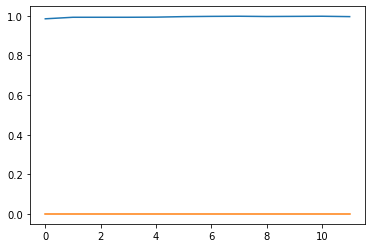

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [136]:
y_test = utils.to_categorical(y_test)

In [137]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_testONE, batch_size=10)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:3])
print('predictions shape:', predictions.shape)


# Evaluate on test data
1538/1538 [==============================] - 6s 4ms/sample - loss: 6.4503 - accuracy: 0.7035
test loss, test acc: [6.450290562378315, 0.70351106]

# Generate predictions for 3 samples
predictions shape: (3, 5)


In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])